In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

## Loading and Preprocessing the dataset

In [2]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("data/magic04.data", names=cols)
df["class"] = (df["class"] == "g").astype("int8")
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


## Train, validation, test datasets

In [3]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

## Scaling and Over Sampling the dataset

In [4]:
def scale_dataset(dataframe: pd.DataFrame, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, y.reshape(-1, 1)))

    return data, X, y

In [5]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [6]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_valid).value_counts())
print(pd.Series(y_test).value_counts())

0    7355
1    7355
dtype: int64
1    2482
0    1322
dtype: int64
1    2495
0    1309
dtype: int64


## Neural Network (NN)

In [7]:
import tensorflow as tf
from sklearn.metrics import classification_report

2023-09-11 15:57:21.522188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, )),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

nn_model.compile(
    optimizer="Adam",
    loss = "binary_crossentropy",
    metrics="accuracy",
)

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


2023-09-11 15:57:23.888621: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
368/368 [==============================] - 5s 10ms/step - loss: 0.4572 - accuracy: 0.8026 - val_loss: 0.5702 - val_accuracy: 0.6798
Epoch 2/50
368/368 [==============================] - 4s 12ms/step - loss: 0.3664 - accuracy: 0.8453 - val_loss: 0.5410 - val_accuracy: 0.7220
Epoch 3/50
368/368 [==============================] - 4s 12ms/step - loss: 0.3512 - accuracy: 0.8529 - val_loss: 0.5118 - val_accuracy: 0.7481
Epoch 4/50
368/368 [==============================] - 4s 10ms/step - loss: 0.3426 - accuracy: 0.8572 - val_loss: 0.4877 - val_accuracy: 0.7600
Epoch 5/50
368/368 [==============================] - 4s 12ms/step - loss: 0.3380 - accuracy: 0.8583 - val_loss: 0.5552 - val_accuracy: 0.7135
Epoch 6/50
368/368 [==============================] - 5s 14ms/step - loss: 0.3325 - accuracy: 0.8620 - val_loss: 0.5164 - val_accuracy: 0.7240
Epoch 7/50
368/368 [==============================] - 5s 12ms/step - loss: 0.3296 - accuracy: 0.8633 - val_loss: 0.5274 - val_accuracy: 0.7264

## Plotting the loss and accuracy

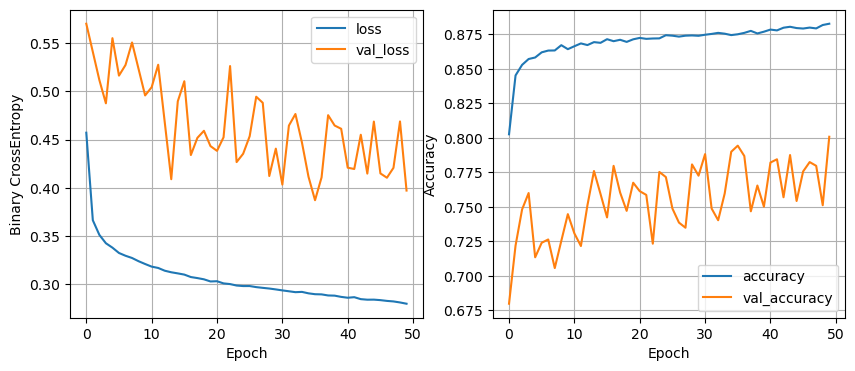

In [10]:
def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history['val_loss'], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary CrossEntropy")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history['val_accuracy'], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)
    plt.show()

plot_history(history)

## Evaluationg the model

In [11]:
y_pred = nn_model.predict(X_test, verbose=0)
y_pred = (y_pred > 0.5).astype("int").reshape(-1, )
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1309
           1       0.89      0.92      0.91      2495

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.86      3804
weighted avg       0.87      0.87      0.87      3804

